# Image Captioning using PyTorch

### 1. Auto-reload by default for modules.

In [1]:
%load_ext autoreload
%autoreload 2

### 2. Importing required modules

In [2]:
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from utils.data_loader import data_loader
from torch.utils.tensorboard import SummaryWriter
from utils.models import Captioner
import torch.optim as optim

### 3. Exlpore the data

In [18]:
df = pd.read_csv("Data/caption_train.csv")

In [19]:
df.head(5)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


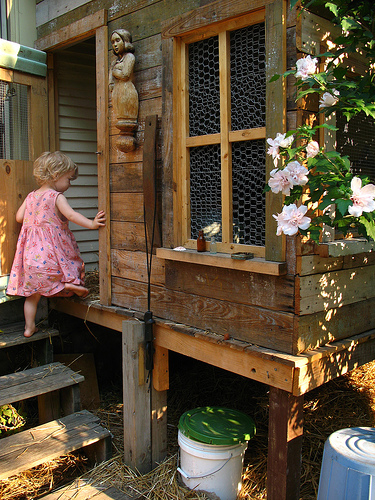

In [45]:
Image.open("Data/Images/train/1000268201_693b08cb0e.jpg")

### 4. Make transformation for the data

In [6]:
img_transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

### 5. Getting the training data in batches

In [7]:
data_loader__training, train_dataset = data_loader(root_dir="./Data/Images/train",
                                caption_file="./Data/caption_train.csv",
                                transform=img_transform)

/home/mhannani/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
for i, (image, caption) in enumerate(data_loader__training):
    print(image.shape)
    print(caption.shape)
    break

torch.Size([32, 3, 299, 299])
torch.Size([20, 32])


In [108]:
def train():
    """
    Train the captioner
    :return:
    """
    print("Training")
    # Apply some transformation to our data
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

    # get the data
    training_data, train_dataset = data_loader(root_dir="./Data/Images/train",
                                               caption_file="./Data/caption_train.csv",
                                               transform=transform, num_workers=6)

    # get the test data
    test_data, test_dataset = data_loader(root_dir="./Data/Images/test",
                                          caption_file="./Data/caption_test.csv",
                                          transform=transform, num_workers=6)

    # get validation data
    valid_data, valid_dataset = data_loader(root_dir="./Data/Images/valid",
                                            caption_file="./Data/caption_valid.csv",
                                            transform=transform, num_workers=6)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True

    # hyperparameters
    embed_size = 256
    hidden_size = 256
    vocabulary_size = len(train_dataset.vocabulary)
    num_layer = 1
    lr = 3e-4
    num_epochs = 101

    # Tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # Initialize model
    model = Captioner(embed_size, hidden_size, vocabulary_size, num_layer).to(device)

    # loss function
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocabulary.stoi["<PAD>"])

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # load checkpoint if already saved
    if load_model:
        step = load_checkpoint(torch.load("checkpoint.pth.tar"), model, optimizer)

    model.train()

    # training process
    for epoch in range(num_epochs):
        running_loss = 0.0

        for index, (images, captions) in enumerate(training_data):
            images = images.to(device)
            captions = captions.to(device)
            output = model(images, captions[:-1])

            loss = criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

            # print statistics
            # accumulate the training loss
            running_loss += loss.item()

            print(f'going through batches the current epoch {epoch}/{num_epochs}')
            print(f"current batch {index} / {len(training_data)}")

        print(f'Epoch: {epoch + 1}/{num_epochs} ... Training loss: {running_loss / len(training_data)}')

        # save the model at this stage
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step
            }
        # save model each 10 epochs
            if (epoch + 1) % 10 == 0:
                save_checkpoint(checkpoint, epoch)


In [109]:
train()

Training
going through batches the current epoch 0/101
current batch 0 / 796
going through batches the current epoch 0/101
current batch 1 / 796
going through batches the current epoch 0/101
current batch 2 / 796
going through batches the current epoch 0/101
current batch 3 / 796
going through batches the current epoch 0/101
current batch 4 / 796
going through batches the current epoch 0/101
current batch 5 / 796
going through batches the current epoch 0/101
current batch 6 / 796
going through batches the current epoch 0/101
current batch 7 / 796
going through batches the current epoch 0/101
current batch 8 / 796
going through batches the current epoch 0/101
current batch 9 / 796
going through batches the current epoch 0/101
current batch 10 / 796
going through batches the current epoch 0/101
current batch 11 / 796
going through batches the current epoch 0/101
current batch 12 / 796
going through batches the current epoch 0/101
current batch 13 / 796
going through batches the current e

KeyboardInterrupt: 

## Inference

In [14]:
from utils.inference import inference
from utils.checkpoints import load_checkpoint

In [31]:
# define the transformation
transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


# hyperparameters
embed_size = 256
hidden_size = 256
vocabulary_size = 2339
num_layer = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get the data
training_data, train_dataset = data_loader(root_dir="Data/Images/train",
                                           caption_file="Data/caption_train.csv",
                                           transform=transform, num_workers=6)

# Initialize model
model = Captioner(embed_size, hidden_size, vocabulary_size, num_layer).to(device)

# load the pretrained model
model, _ = load_checkpoint(torch.load("checkpoints/checkpoint_num_39__21_11_2021__16_33_06.pth.tar",
                                      map_location=torch.device('cpu')), model)

model.eval();


==< Loading checkpoint >==


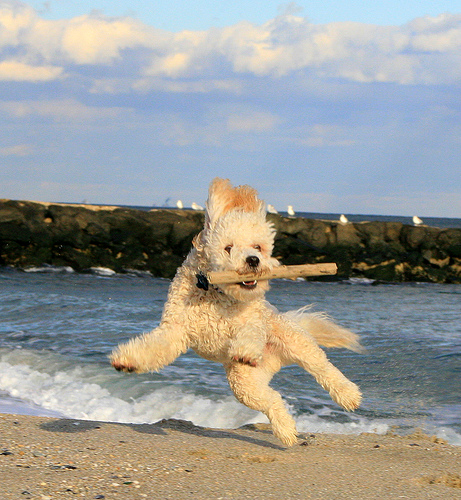

In [36]:
Image.open("Data/Images/test/335588286_f67ed8c9f9.jpg")

In [35]:
inference(model, train_dataset, transform, device, image_name="335588286_f67ed8c9f9", show_image=True)

|==================< Ground-truth captions >==================|
A fluffy dog holds a stick in its mouth on a beach .
a small white dog catching a stick on the shore at the beach .
A white dog has caught a stick on the beach beside the ocean .
A white dog is running along a beach with a stick in its mouth .
A white dog on a beach is carrying a stick in its mouth .
|====================< Generated caption >====================|
<SOS> a white dog is running through the grass . <EOS>
